# XG BOOST

Librerias

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,
                             f1_score, precision_score, recall_score, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)

from sklearn.model_selection import StratifiedKFold
from tools import optimizar_threshold_costo_cv, evaluate_model

Dataset

In [63]:
dataset = pd.read_csv('../../data/processed/fraud_dataset_processed.csv')

In [64]:
# Mover la columna "fraude" al final a la derecha
# Nos quedamos solo con las columnas numéricas (más la columna 'fraude' si existe)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

# EXCLUIR columnas que pueden causar data leakage
columns_to_exclude = ['fraude', 'row_id', 'Unnamed: 0', 'score']
if 'fraude' in numeric_cols:
    numeric_cols.remove('fraude')
for col in columns_to_exclude:
    if col in numeric_cols:
        numeric_cols.remove(col)

# Agregar 'fraude' al final
if 'fraude' in dataset.columns:
    numeric_cols.append('fraude')

dataset = dataset[numeric_cols]

# Verificar columnas usadas
print(f"Total de columnas numéricas (sin 'fraude'): {len(numeric_cols) - 1}")
print(f"Columnas usadas: {numeric_cols[:-1] if 'fraude' in numeric_cols else numeric_cols}")

Total de columnas numéricas (sin 'fraude'): 45
Columnas usadas: ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'k', 'l', 'm', 'n', 'q', 'r', 's', 'monto', 'o_is_N', 'o_is_Y', 'o_is_NA', 'b_imputado', 'c_imputado', 'd_imputado', 'f_imputado', 'q_imputado', 'l_imputado', 'm_imputado', 'categoria_id_target_enc', 'categoria_id_freq_enc', 'pais_target_enc', 'pais_freq_enc', 'producto_num_chars', 'producto_num_words', 'producto_num_special_chars', 'producto_avg_word_len', 'producto_freq', 'hora', 'dia_semana', 'dia_mes', 'mes', 'es_fin_de_semana', 'es_nocturno', 'es_horario_laboral', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos']


In [65]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Obtener nombres de columnas para análisis
feature_names = dataset.columns[:-1].tolist()

# Verificar distribución de clases
print("=" * 80)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 80)
print(f"Clase 0 (No Fraude): {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"Clase 1 (Fraude):    {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.2f}%)")
print(f"Total:               {len(y):,}")

# Calcular ratio de desbalance para balanceo
fraud_count = np.sum(y == 1)
non_fraud_count = np.sum(y == 0)
if fraud_count > 0:
    scale_pos_weight = non_fraud_count / fraud_count
    print(f"\nRatio de desbalance (scale_pos_weight): {scale_pos_weight:.2f}")
else:
    scale_pos_weight = 1.0
    print("\n⚠️ ERROR: No hay casos de fraude!")

# ⚠️ VERIFICAR DATA LEAKAGE: Correlación con target
print("\n" + "=" * 80)
print("VERIFICACIÓN DE DATA LEAKAGE")
print("=" * 80)
X_df = pd.DataFrame(X, columns=feature_names)
y_series = pd.Series(y)

# Calcular correlaciones con el target
correlations = X_df.corrwith(y_series).abs().sort_values(ascending=False)
print("\nTop 10 columnas con mayor correlación con 'fraude':")
print(correlations.head(10))

# Verificar si hay correlación perfecta o casi perfecta
high_corr = correlations[correlations > 0.95]
if len(high_corr) > 0:
    print(f"\n⚠️ ADVERTENCIA: {len(high_corr)} columna(s) con correlación > 0.95 con el target:")
    print(high_corr)
    print("\n⚠️ Esto puede indicar DATA LEAKAGE!")
else:
    print("\n✅ No se encontraron correlaciones perfectas (>0.95) con el target")

# Verificar si alguna columna predice perfectamente el target
print("\n" + "-" * 80)
print("Verificando si alguna columna predice perfectamente el target...")
perfect_predictors = []
for col in feature_names:
    col_idx = feature_names.index(col)
    col_values = X[:, col_idx]
    
    # Verificar si los valores únicos de la columna coinciden perfectamente con el target
    # (esto indicaría que la columna es casi idéntica al target)
    unique_vals = np.unique(col_values)
    
    # Si la columna tiene solo 2 valores únicos (como el target), verificar si coincide
    if len(unique_vals) == 2:
        # Crear un mapeo binario
        val0, val1 = unique_vals
        col_binary = (col_values == val1).astype(int)
        if np.array_equal(col_binary, y):
            perfect_predictors.append(col)
            print(f"⚠️ {col}: Predice PERFECTAMENTE el target (coincidencia 100%)")

if len(perfect_predictors) > 0:
    print(f"\n⚠️ ADVERTENCIA CRÍTICA: {len(perfect_predictors)} columna(s) predicen perfectamente el target:")
    print(perfect_predictors)
    print("⚠️ Estas columnas deben ser ELIMINADAS - son DATA LEAKAGE!")
else:
    print("✅ No se encontraron columnas que predigan perfectamente el target")

DISTRIBUCIÓN DE CLASES
Clase 0 (No Fraude): 242,498 (97.00%)
Clase 1 (Fraude):    7,502 (3.00%)
Total:               250,000

Ratio de desbalance (scale_pos_weight): 32.32

VERIFICACIÓN DE DATA LEAKAGE

Top 10 columnas con mayor correlación con 'fraude':
categoria_id_target_enc    0.234866
o_is_N                     0.222080
o_is_NA                    0.173683
n                          0.134382
l                          0.091730
l_imputado                 0.091730
s                          0.083816
m                          0.073017
m_imputado                 0.072965
q                          0.060914
dtype: float64

✅ No se encontraron correlaciones perfectas (>0.95) con el target

--------------------------------------------------------------------------------
Verificando si alguna columna predice perfectamente el target...
✅ No se encontraron columnas que predigan perfectamente el target


In [66]:
# IMPORTANTE: Convertir la columna 'fraude' a binaria (0/1) si fue normalizada
if 'fraude' in dataset.columns:
    # Verificar valores únicos
    unique_values = dataset['fraude'].unique()
    print(f"Valores únicos en 'fraude' (primeros 10): {sorted(unique_values)[:10]}")
    print(f"Tipo de datos: {dataset['fraude'].dtype}")
    print(f"Min: {dataset['fraude'].min()}, Max: {dataset['fraude'].max()}")
    
    # Si tiene valores continuos (normalizados), convertir a binario
    if dataset['fraude'].dtype in ['float64', 'float32']:
        # Si los valores están normalizados (entre 0 y 1), convertir a binario
        if dataset['fraude'].min() >= 0 and dataset['fraude'].max() <= 1:
            # Convertir: > 0.5 = 1, <= 0.5 = 0
            dataset['fraude'] = (dataset['fraude'] > 0.5).astype(int)
            print("✅ Columna 'fraude' convertida de valores normalizados a binaria (0/1)")
        else:
            # Si tiene valores negativos o > 1, usar > 0 como criterio
            dataset['fraude'] = (dataset['fraude'] > 0).astype(int)
            print("✅ Columna 'fraude' convertida a binaria usando > 0 como criterio")
    elif dataset['fraude'].dtype in ['int64', 'int32']:
        # Si ya es entero, verificar si es binario
        unique_ints = set(dataset['fraude'].unique())
        if unique_ints != {0, 1}:
            # Normalizar: cualquier valor > 0 = 1, 0 = 0
            dataset['fraude'] = (dataset['fraude'] > 0).astype(int)
            print("✅ Columna 'fraude' normalizada a binaria (0/1)")
        else:
            print("✅ Columna 'fraude' ya es binaria (0/1)")
    
    # Verificar resultado
    print(f"\nDespués de la conversión:")
    print(f"  Valores únicos: {sorted(dataset['fraude'].unique())}")
    print(f"  Tipo: {dataset['fraude'].dtype}")


Valores únicos en 'fraude' (primeros 10): [np.int64(0), np.int64(1)]
Tipo de datos: int64
Min: 0, Max: 1
✅ Columna 'fraude' ya es binaria (0/1)

Después de la conversión:
  Valores únicos: [np.int64(0), np.int64(1)]
  Tipo: int64


Split Train Test

In [67]:
# Asegurar que y sea binario (0/1) y de tipo entero
y = y.astype(float)  # Primero convertir a float para manejar cualquier tipo
y = (y > 0.5).astype(int)  # Convertir a binario: > 0.5 = 1, <= 0.5 = 0

# Verificar que solo tenga valores 0 y 1
unique_y = np.unique(y)
print(f"Valores únicos en y: {unique_y}")
print(f"Tipo de y: {y.dtype}")

if len(unique_y) > 2 or not all(val in [0, 1] for val in unique_y):
    print(f"⚠️ Advertencia: y tiene valores {unique_y}, forzando a binario")
    y = (y > 0).astype(int)
    print("✅ y convertido a binario (0/1)")

# Verificar distribución de clases
print("\n" + "=" * 80)
print("DISTRIBUCIÓN DE CLASES (DESPUÉS DE CONVERSIÓN)")
print("=" * 80)
print(f"Clase 0 (No Fraude): {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"Clase 1 (Fraude):    {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.2f}%)")
print(f"Total:               {len(y):,}")

# Recalcular ratio de desbalance
fraud_count = np.sum(y == 1)
non_fraud_count = np.sum(y == 0)

if fraud_count > 0:
    scale_pos_weight = non_fraud_count / fraud_count
    print(f"\nRatio de desbalance (scale_pos_weight): {scale_pos_weight:.2f}")
else:
    print("\n⚠️ ERROR: No hay casos de fraude en el dataset!")
    scale_pos_weight = 1.0


Valores únicos en y: [0 1]
Tipo de y: int64

DISTRIBUCIÓN DE CLASES (DESPUÉS DE CONVERSIÓN)
Clase 0 (No Fraude): 242,498 (97.00%)
Clase 1 (Fraude):    7,502 (3.00%)
Total:               250,000

Ratio de desbalance (scale_pos_weight): 32.32


In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Verificar si hay datos duplicados entre train y test (posible causa de overfitting)
print("=" * 80)
print("VERIFICACIÓN DE DATOS DUPLICADOS")
print("=" * 80)
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Convertir a tuplas para comparar filas completas
train_tuples = [tuple(row) for row in X_train]
test_tuples = [tuple(row) for row in X_test]
train_set = set(train_tuples)
test_set = set(test_tuples)

duplicates = train_set.intersection(test_set)
if len(duplicates) > 0:
    print(f"⚠️ ADVERTENCIA: {len(duplicates)} filas idénticas entre train y test!")
    print("   Esto puede causar overfitting aparente.")
else:
    print("✅ No se encontraron filas idénticas entre train y test")

print(f"\nTrain size: {len(X_train):,}")
print(f"Test size:  {len(X_test):,}")

VERIFICACIÓN DE DATOS DUPLICADOS
✅ No se encontraron filas idénticas entre train y test

Train size: 200,000
Test size:  50,000


Entrenamos

In [69]:
from xgboost import XGBClassifier

# Asegurar que y_train sea binario y entero
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Calcular scale_pos_weight para el conjunto de entrenamiento (BALANCEO)
fraud_count_train = np.sum(y_train == 1)
non_fraud_count_train = np.sum(y_train == 0)

print("=" * 80)
print("BALANCEO DE CLASES")
print("=" * 80)
print(f"No Fraude (train): {non_fraud_count_train:,}")
print(f"Fraude (train):    {fraud_count_train:,}")

if fraud_count_train > 0 and non_fraud_count_train > 0:
    scale_pos_weight = non_fraud_count_train / fraud_count_train
    print(f"scale_pos_weight:  {scale_pos_weight:.2f}")
else:
    print("⚠️ ERROR: No hay suficientes muestras de ambas clases!")
    scale_pos_weight = 1.0

# Entrenar modelo con balanceo
print("\n" + "=" * 80)
print("ENTRENANDO MODELO CON BALANCEO")
print("=" * 80)
classifier = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Balanceo de clases
    random_state=0,
    eval_metric='logloss',
    n_estimators=100
)
classifier.fit(X_train, y_train)
print("✅ Modelo entrenado con balanceo de clases")

BALANCEO DE CLASES
No Fraude (train): 193,968
Fraude (train):    6,032
scale_pos_weight:  32.16

ENTRENANDO MODELO CON BALANCEO
✅ Modelo entrenado con balanceo de clases


Selección de Features


SELECCIÓN DE FEATURES CON RFECV (OPTIMIZADO PARA F1)

Top 15 features por importancia (modelo inicial):
                    feature  importance
33            producto_freq    0.301212
15                   o_is_N    0.112646
17                  o_is_NA    0.077485
25  categoria_id_target_enc    0.059246
0                         a    0.042335
39              es_nocturno    0.037868
16                   o_is_Y    0.034791
13                        s    0.029265
10                        n    0.028528
23               l_imputado    0.015444
24               m_imputado    0.014820
5                         f    0.013586
8                         l    0.013538
9                         m    0.012237
28            pais_freq_enc    0.011566

Usando muestra de 195,000 registros para RFECV
Muestra: 194,999 registros
  - No Fraude: 189,118
  - Fraude: 5,881

Iniciando RFECV (esto puede tardar varios minutos)...
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estim

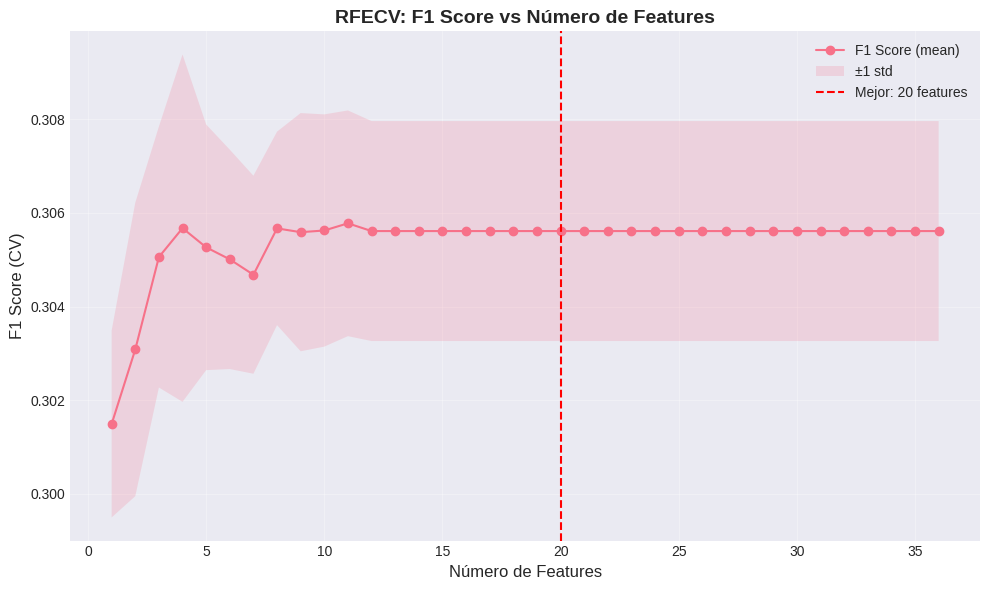

In [70]:
# ============================================================================
# SELECCIÓN DE FEATURES CON RFECV (OPTIMIZADO PARA F1 SCORE)
# ============================================================================

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import time

print("=" * 80)
print("SELECCIÓN DE FEATURES CON RFECV (OPTIMIZADO PARA F1)")
print("=" * 80)

# Mostrar importancia inicial del modelo
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 features por importancia (modelo inicial):")
print(feature_importance.head(15))

# Usar muestra para RFECV (es más lento pero más preciso)
sample_size = 195000
print(f"\nUsando muestra de {sample_size:,} registros para RFECV")

# Crear muestra estratificada para mantener proporción de clases
sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - (sample_size/len(X_train)), random_state=0)
train_idx, _ = next(sss.split(X_train, y_train))
X_train_rfecv = X_train[train_idx]
y_train_rfecv = y_train[train_idx]

print(f"Muestra: {len(X_train_rfecv):,} registros")
print(f"  - No Fraude: {np.sum(y_train_rfecv == 0):,}")
print(f"  - Fraude: {np.sum(y_train_rfecv == 1):,}")

# Crear estimador base (más simple para RFECV - velocidad)
estimator = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=50,  # Menos árboles para velocidad
    max_depth=3,
    learning_rate=0.1,
    random_state=0,
    eval_metric='logloss',
    n_jobs=2
)

# RFECV optimizando F1 Score
print("\n" + "=" * 80)
print("Iniciando RFECV (esto puede tardar varios minutos)...")
print("=" * 80)

rfecv = RFECV(
    estimator=estimator,
    step=1,  # Eliminar 1 feature a la vez
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),  # 3 folds
    scoring='f1',  # ⭐ OPTIMIZAR F1 DIRECTAMENTE
    n_jobs=2,
    min_features_to_select=10,  # Mínimo 10 features
    verbose=1
)

start_time = time.time()
rfecv.fit(X_train_rfecv, y_train_rfecv)
elapsed_time = time.time() - start_time

print(f"\n✅ RFECV completado en {elapsed_time/60:.2f} minutos")

# Features seleccionadas
selected_features = [feature_names[i] for i in range(len(feature_names)) if rfecv.support_[i]]

# Obtener mejor score
best_score_idx = np.argmax(rfecv.cv_results_['mean_test_score'])
best_score = rfecv.cv_results_['mean_test_score'][best_score_idx]
best_std = rfecv.cv_results_['std_test_score'][best_score_idx]

print("\n" + "=" * 80)
print("RESULTADOS DE RFECV")
print("=" * 80)
print(f"Mejor número de features: {rfecv.n_features_}")
print(f"Mejor F1 Score (CV): {best_score:.4f} ± {best_std:.4f}")
print(f"Features seleccionadas: {len(selected_features)} de {len(feature_names)}")

# Mostrar features seleccionadas con su importancia
print(f"\n✅ Features seleccionadas ({len(selected_features)}):")
selected_importance = feature_importance[feature_importance['feature'].isin(selected_features)].sort_values('importance', ascending=False)
for i, (idx, row) in enumerate(selected_importance.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:30s}: {row['importance']:.6f}")

# Aplicar selección
selected_indices = [feature_names.index(f) for f in selected_features]
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]
feature_names_selected = selected_features

# Actualizar variables para usar features seleccionadas
X_train = X_train_selected
X_test = X_test_selected
feature_names = feature_names_selected

print(f"\n✅ Datos actualizados:")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   Features: {len(feature_names)}")

# Visualizar evolución del F1 score según número de features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         rfecv.cv_results_['mean_test_score'], 'o-', label='F1 Score (mean)')
plt.fill_between(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
                 rfecv.cv_results_['mean_test_score'] - rfecv.cv_results_['std_test_score'],
                 rfecv.cv_results_['mean_test_score'] + rfecv.cv_results_['std_test_score'],
                 alpha=0.2, label='±1 std')
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', 
            label=f'Mejor: {rfecv.n_features_} features')
plt.xlabel('Número de Features', fontsize=12)
plt.ylabel('F1 Score (CV)', fontsize=12)
plt.title('RFECV: F1 Score vs Número de Features', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Optimización de Hiperparámetros (F1 Score)

In [71]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import time

# Mejor OPTIMIZACIÓN DE HIPERPARÁMETROS - F1 SCORE
print("=" * 80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - F1 SCORE (OPTIMIZADO CON EARLY STOPPING)")
print("=" * 80)

# Usar una muestra más grande para optimización (aprovechando mejor equipo)
sample_size = min(120000, len(X_train))  # Significativamente más grande
print(f"\nUsando muestra de {sample_size:,} registros para optimización")

# Crear muestra estratificada para mantener proporción de clases
sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - (sample_size/len(X_train)), random_state=42)
train_idx, _ = next(sss.split(X_train, y_train))
X_train_sample = X_train[train_idx]
y_train_sample = y_train[train_idx]

print(f"Muestra: {len(X_train_sample):,} registros")
print(f"  - No Fraude: {np.sum(y_train_sample == 0):,}")
print(f"  - Fraude: {np.sum(y_train_sample == 1):,}")

# Grid de hiperparámetros más amplio aprovechando el mejor hardware
# Nota: n_estimators se ajustará para usar early stopping en el entrenamiento final
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.85, 0.9, 0.95, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.85, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2, 2.5, 3, 4]
}

# Crear modelo base con scale_pos_weight
base_model = XGBClassifier(
    n_jobs=1,               # <---- IMPORTANTE
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
# Aumentar número de combinaciones para mejor exploración
print("\nIniciando búsqueda de hiperparámetros (OPTIMIZADO - más iteraciones)...")
print("Esto puede tardar bastante si hay muchas combinaciones, pero el resultado será mejor.")

start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1',
    cv=5,
    n_jobs=-1,              # <---- SOLO ACÁ PARALELIZÁS
    verbose=2
)

random_search.fit(X_train_sample, y_train_sample)

elapsed_time = time.time() - start_time
print(f"\n✅ Búsqueda completada en {elapsed_time/60:.2f} minutos")

# Mostrar mejores parámetros
print("\n" + "=" * 80)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("=" * 80)
best_params = random_search.best_params_.copy()  # Copiar para modificar
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1 Score (CV): {random_search.best_score_:.4f}")

# Entrenar modelo final con mejores parámetros usando TODO el dataset
print("\n" + "=" * 80)
print("ENTRENANDO MODELO OPTIMIZADO FINAL CON EARLY STOPPING")
print("=" * 80)

# ⬆️ USAR TODO EL DATASET (sin limitación)
X_train_final = X_train
y_train_final = y_train
print(f"✅ Usando TODOS los {len(X_train):,} registros para entrenamiento final")
print(f"   - No Fraude: {np.sum(y_train_final == 0):,}")
print(f"   - Fraude: {np.sum(y_train_final == 1):,}")

# Crear conjunto de validación para early stopping (15% del training)
print("\nCreando conjunto de validación para early stopping...")
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train_final, y_train_final, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_train_final
)

print(f"   Training: {len(X_train_fit):,} registros")
print(f"   Validation: {len(X_val):,} registros")
print(f"   - No Fraude (val): {np.sum(y_val == 0):,}")
print(f"   - Fraude (val): {np.sum(y_val == 1):,}")

# Remover n_estimators de best_params para usar early stopping
# Usaremos un número alto y early stopping lo detendrá
n_estimators_final = best_params.pop('n_estimators', 600)
# Usar un número alto para permitir que early stopping funcione
n_estimators_final = max(1000, n_estimators_final * 2)  # Al menos 1000 o el doble del encontrado

print(f"\nConfigurando early stopping:")
print(f"   n_estimators máximo: {n_estimators_final}")
print(f"   early_stopping_rounds: 50")
print(f"   eval_metric: logloss")

classifier_optimized = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1,  # usar todos los cores para entrenamiento final
    n_estimators=n_estimators_final,
    early_stopping_rounds=50,  # ⬆️ EARLY STOPPING: detener si no mejora en 50 rondas
    **best_params
)

print("\nEntrenando modelo con early stopping...")
classifier_optimized.fit(
    X_train_fit, y_train_fit,
    eval_set=[(X_val, y_val)],  # ⬆️ EARLY STOPPING: usar conjunto de validación
    verbose=100  # Mostrar progreso cada 100 iteraciones
)

print("✅ Modelo optimizado entrenado con early stopping")
print(f"   Número de árboles utilizados: {classifier_optimized.best_iteration + 1 if hasattr(classifier_optimized, 'best_iteration') else n_estimators_final}")

# Actualizar classifier para usar el modelo optimizado
classifier = classifier_optimized

OPTIMIZACIÓN DE HIPERPARÁMETROS - F1 SCORE (OPTIMIZADO CON EARLY STOPPING)

Usando muestra de 120,000 registros para optimización
Muestra: 120,000 registros
  - No Fraude: 116,381
  - Fraude: 3,619

Iniciando búsqueda de hiperparámetros (OPTIMIZADO - más iteraciones)...
Esto puede tardar bastante si hay muchas combinaciones, pero el resultado será mejor.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.85, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.5, subsample=0.85; total time=   1.8s
[CV] END colsample_bytree=0.85, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.5, subsample=0.85; total time=   3.0s
[CV] END colsample_bytree=0.85, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.5, subsample=0.85; total time=   3.9s
[CV] END colsample_bytree=0.85, gamma=0.

Matriz de confusio

EVALUACIÓN DEL MODELO OPTIMIZADO

🎯 F1-SCORE: 0.5217 (52.17%)
   Precision: 0.5087 (50.87%)
   Recall:    0.5354 (53.54%)

Matriz de Confusión:
[[47770   760]
 [  683   787]]

Verdaderos Positivos (TP): 787
Falsos Negativos (FN):     683
Falsos Positivos (FP):     760
Verdaderos Negativos (TN): 47,770

IMPORTANCIA DE FEATURES (Top 10)
                    feature  importance
17            producto_freq    0.260877
11                  o_is_NA    0.252462
10                   o_is_N    0.133122
0                         a    0.088709
16  categoria_id_target_enc    0.043865
8                         n    0.043216
18              es_nocturno    0.023198
4                         f    0.015745
9                         s    0.015516
7                         m    0.015096


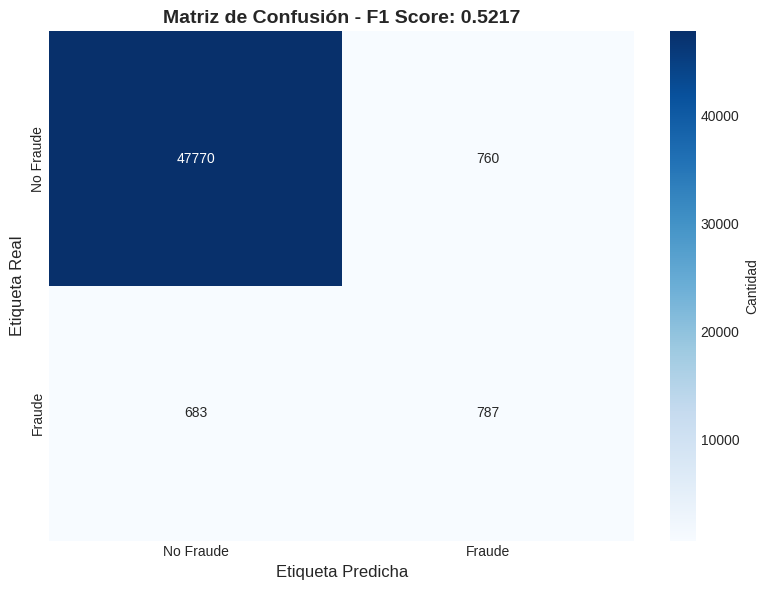

In [72]:
# Obtener probabilidades para optimización de threshold
y_proba = classifier.predict_proba(X_test)[:, 1]

# Predicciones con threshold por defecto (0.5)
y_pred = classifier.predict(X_test)

# Calcular F1 Score (métrica principal)
f1 = f1_score(y_test, y_pred)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=" * 80)
print("EVALUACIÓN DEL MODELO OPTIMIZADO")
print("=" * 80)

# Calcular métricas adicionales
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\n🎯 F1-SCORE: {f1:.4f} ({f1*100:.2f}%)")
print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")

# ⚠️ ADVERTENCIA si el F1 es perfecto
if f1 >= 0.999:
    print("\n" + "⚠️" * 40)
    print("⚠️ ADVERTENCIA: F1 Score perfecto (1.0000) - Posibles causas:")
    print("   1. DATA LEAKAGE: Alguna columna contiene información del target")
    print("   2. OVERFITTING EXTREMO: El modelo memorizó los datos")
    print("   3. DATOS DUPLICADOS: Train y test tienen datos duplicados")
    print("   4. COLUMNA PERFECTAMENTE PREDICTIVA: Alguna feature es casi idéntica al target")
    print("⚠️" * 40)

print("\nMatriz de Confusión:")
print(cm)
print(f"\nVerdaderos Positivos (TP): {tp:,}")
print(f"Falsos Negativos (FN):     {fn:,}")
print(f"Falsos Positivos (FP):     {fp:,}")
print(f"Verdaderos Negativos (TN): {tn:,}")

# Verificar importancia de features para detectar posibles problemas
print("\n" + "=" * 80)
print("IMPORTANCIA DE FEATURES (Top 10)")
print("=" * 80)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# Visualización de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'],
            cbar_kws={'label': 'Cantidad'})
plt.title(f'Matriz de Confusión - F1 Score: {f1:.4f}', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.show()

OPTIMIZACIÓN DE THRESHOLD - MAXIMIZAR F1 SCORE

📊 RESULTADOS DE OPTIMIZACIÓN:
   Threshold por defecto (0.5):
      F1 Score: 0.5217
      Precision: 0.5087
      Recall: 0.5354

   Threshold óptimo: 0.6103
      F1 Score: 0.5288 (52.88%)
      Precision: 0.5568 (55.68%)
      Recall: 0.5034 (50.34%)

   Mejora en F1: 0.0070 (1.4%)

EVALUACIÓN CON THRESHOLD ÓPTIMO

🎯 F1-SCORE: 0.5288 (52.88%)
   Precision: 0.5568 (55.68%)
   Recall:    0.5034 (50.34%)

Matriz de Confusión:
[[47941   589]
 [  730   740]]

Verdaderos Positivos (TP): 740
Falsos Negativos (FN):     730
Falsos Positivos (FP):     589
Verdaderos Negativos (TN): 47,941

COMPARACIÓN: Threshold 0.5 vs Threshold Óptimo
  Métrica  Threshold 0.5  Threshold Óptimo  Diferencia
 F1 Score       0.521710          0.528760    0.007050
Precision       0.508727          0.556810    0.048083
   Recall       0.535374          0.503401   -0.031973
       TP     787.000000        740.000000  -47.000000
       FP     760.000000        589.0000

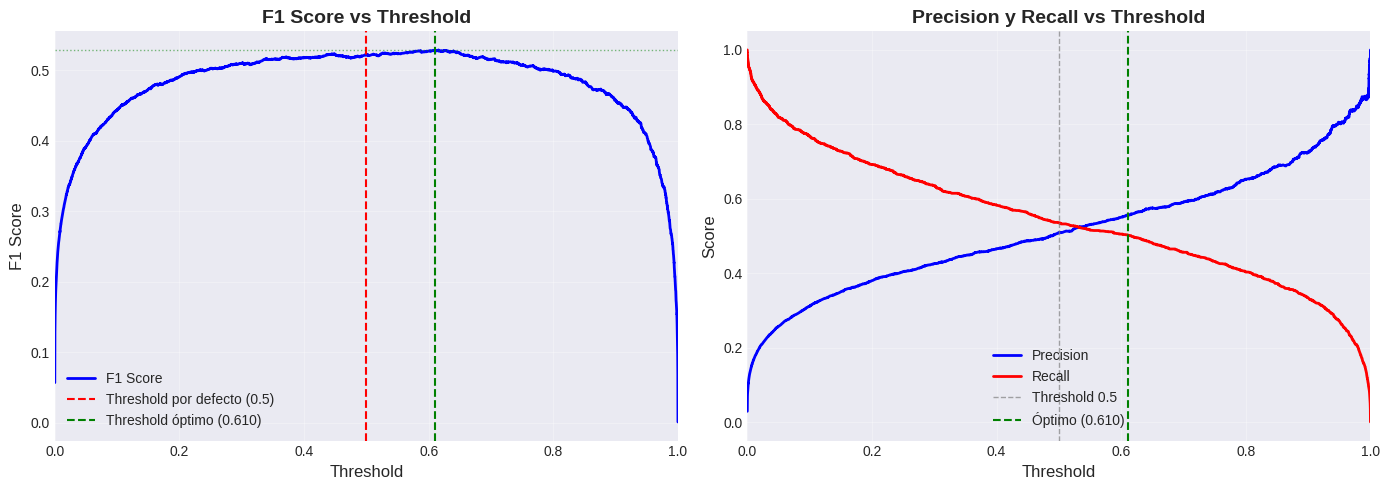


✅ Predicciones actualizadas con threshold óptimo: 0.6103


In [73]:
from sklearn.metrics import precision_recall_curve

# ============================================================================
# OPTIMIZACIÓN DE THRESHOLD PARA MAXIMIZAR F1 SCORE
# ============================================================================

print("=" * 80)
print("OPTIMIZACIÓN DE THRESHOLD - MAXIMIZAR F1 SCORE")
print("=" * 80)

# Calcular precision, recall para diferentes thresholds
precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_test, y_proba)

# Calcular F1 para cada threshold
f1_scores_curve = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)
f1_scores_curve = np.nan_to_num(f1_scores_curve)  # Manejar divisiones por 0

# Encontrar threshold óptimo (máximo F1)
optimal_idx = np.argmax(f1_scores_curve)
optimal_threshold = thresholds_curve[optimal_idx]
optimal_f1 = f1_scores_curve[optimal_idx]
optimal_precision = precision_curve[optimal_idx]
optimal_recall = recall_curve[optimal_idx]

print(f"\n📊 RESULTADOS DE OPTIMIZACIÓN:")
print(f"   Threshold por defecto (0.5):")
print(f"      F1 Score: {f1:.4f}")
print(f"      Precision: {precision:.4f}")
print(f"      Recall: {recall:.4f}")
print(f"\n   Threshold óptimo: {optimal_threshold:.4f}")
print(f"      F1 Score: {optimal_f1:.4f} ({optimal_f1*100:.2f}%)")
print(f"      Precision: {optimal_precision:.4f} ({optimal_precision*100:.2f}%)")
print(f"      Recall: {optimal_recall:.4f} ({optimal_recall*100:.2f}%)")
print(f"\n   Mejora en F1: {optimal_f1 - f1:.4f} ({(optimal_f1 - f1)/f1*100:.1f}%)")

# Aplicar threshold óptimo
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
f1_optimal = f1_score(y_test, y_pred_optimal)
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)

# Matriz de confusión con threshold óptimo
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()

print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO")
print("=" * 80)
print(f"\n🎯 F1-SCORE: {f1_optimal:.4f} ({f1_optimal*100:.2f}%)")
print(f"   Precision: {precision_optimal:.4f} ({precision_optimal*100:.2f}%)")
print(f"   Recall:    {recall_optimal:.4f} ({recall_optimal*100:.2f}%)")

print("\nMatriz de Confusión:")
print(cm_optimal)
print(f"\nVerdaderos Positivos (TP): {tp_opt:,}")
print(f"Falsos Negativos (FN):     {fn_opt:,}")
print(f"Falsos Positivos (FP):     {fp_opt:,}")
print(f"Verdaderos Negativos (TN): {tn_opt:,}")

# Comparación de resultados
print("\n" + "=" * 80)
print("COMPARACIÓN: Threshold 0.5 vs Threshold Óptimo")
print("=" * 80)
comparison = pd.DataFrame({
    'Métrica': ['F1 Score', 'Precision', 'Recall', 'TP', 'FP', 'FN', 'TN'],
    'Threshold 0.5': [f1, precision, recall, tp, fp, fn, tn],
    'Threshold Óptimo': [f1_optimal, precision_optimal, recall_optimal, tp_opt, fp_opt, fn_opt, tn_opt],
    'Diferencia': [
        f1_optimal - f1,
        precision_optimal - precision,
        recall_optimal - recall,
        tp_opt - tp,
        fp_opt - fp,
        fn_opt - fn,
        tn_opt - tn
    ]
})
print(comparison.to_string(index=False))

# Visualización: F1 Score vs Threshold
plt.figure(figsize=(14, 5))

# Gráfico 1: F1 Score vs Threshold
plt.subplot(1, 2, 1)
plt.plot(thresholds_curve, f1_scores_curve[:-1], 'b-', linewidth=2, label='F1 Score')
plt.axvline(x=0.5, color='r', linestyle='--', linewidth=1.5, label='Threshold por defecto (0.5)')
plt.axvline(x=optimal_threshold, color='g', linestyle='--', linewidth=1.5, label=f'Threshold óptimo ({optimal_threshold:.3f})')
plt.axhline(y=optimal_f1, color='g', linestyle=':', linewidth=1, alpha=0.5)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.xlim([0, 1])

# Gráfico 2: Precision y Recall vs Threshold
plt.subplot(1, 2, 2)
plt.plot(thresholds_curve, precision_curve[:-1], 'b-', linewidth=2, label='Precision')
plt.plot(thresholds_curve, recall_curve[:-1], 'r-', linewidth=2, label='Recall')
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Threshold 0.5')
plt.axvline(x=optimal_threshold, color='g', linestyle='--', linewidth=1.5, label=f'Óptimo ({optimal_threshold:.3f})')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision y Recall vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.xlim([0, 1])

plt.tight_layout()
plt.show()

# Actualizar predicciones para usar threshold óptimo
y_pred = y_pred_optimal
f1 = f1_optimal
precision = precision_optimal
recall = recall_optimal
cm = cm_optimal
tn, fp, fn, tp = tn_opt, fp_opt, fn_opt, tp_opt

print(f"\n✅ Predicciones actualizadas con threshold óptimo: {optimal_threshold:.4f}")


Optimizar threshold por costo

In [76]:
# Optimizar threshold por costo usando Cross-Validation
# Definir costos: FP (False Positive) y FN (False Negative)
# En detección de fraude, un FN (no detectar fraude) suele ser más costoso que un FP (falsas alarmas)
costo_fp = 5.0   # Costo de un False Positive (bloquear transacción legítima)
costo_fn = 100.0  # Costo de un False Negative (no detectar fraude real)

# Configurar Cross-Validation estratificado (mantiene proporción de clases)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

print("=" * 80)
print("OPTIMIZACIÓN DE THRESHOLD POR COSTO")
print("=" * 80)
print(f"Costo FP (False Positive): {costo_fp}")
print(f"Costo FN (False Negative): {costo_fn}")
print(f"Ratio costo FN/FP: {costo_fn/costo_fp:.1f}x")
print("\nOptimizando threshold usando Cross-Validation...")

# Optimizar threshold por costo
# Crear una copia del modelo sin early stopping para CV
from sklearn.base import clone
from xgboost import XGBClassifier

# Obtener parámetros del modelo original
model_params = classifier.get_params()
# Crear nuevo modelo sin early stopping
classifier_cv = XGBClassifier(**{k: v for k, v in model_params.items() 
                                    if k != 'early_stopping_rounds'})
classifier_cv.set_params(early_stopping_rounds=None)

resultados_optimizacion = optimizar_threshold_costo_cv(
    model=classifier_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="XGBoost"
)

# Guardar threshold óptimo
threshold_optimo_costo = resultados_optimizacion['threshold_optimo']
costo_minimo = resultados_optimizacion['costo_minimo']

print(f"\n{'='*80}")
print(f"RESUMEN DE OPTIMIZACIÓN")
print(f"{'='*80}")
print(f"Threshold óptimo (por costo): {threshold_optimo_costo:.4f}")
print(f"Costo mínimo por 1000 registros: {costo_minimo:.2f}")
print(f"Robustez: {resultados_optimizacion['robustez']}")

OPTIMIZACIÓN DE THRESHOLD POR COSTO
Costo FP (False Positive): 5.0
Costo FN (False Negative): 100.0
Ratio costo FN/FP: 20.0x

Optimizando threshold usando Cross-Validation...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.0151
   Costo mínimo por 1000 registros: 906.75
   FP ajustado: 19370
   FN ajustado: 845

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0145
   Robustez: Muy robusto ✅
   Costo medio por fold: 906.75 ± 13.11

RESUMEN DE OPTIMIZACIÓN
Threshold óptimo (por costo): 0.0151
Costo mínimo por 1000 registros: 906.75
Robustez: Muy robusto


Evaluación con threshold óptimo por costo


RESULTADOS TEST (Threshold Óptimo por Costo)
EVALUACIÓN DEL MODELO: XGBoost - Test

📌 Threshold usado: 0.0151

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,530 (97.06%)
   Clase 1 (Fraude):    1,470 (2.94%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.8818
   F1 Score:            0.3088 ⭐
   Precision:           0.1865
   Recall (Sensitivity): 0.8980
   Specificity:         0.8813
   ROC AUC:             0.9560
   Average Precision:   0.5553

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.2734
   Matthews Corr Coef:  0.3776
   NPV:                 0.9965
   False Positive Rate: 0.1187

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.1865
   Recall:             0.8980
   F1 Score:           0.3088
   Cohen's Kappa:      0.2734
   Matthews Corr Coef: 0.3776
   Tasa positivos:     0.1416

💰 COSTO:
   Costo por 1000 registros: 875.90
   (Costo FP: 5.0, Costo FN: 100.0)

🔢 MATRIZ DE CONFUSIÓN:
                    Predicción
            

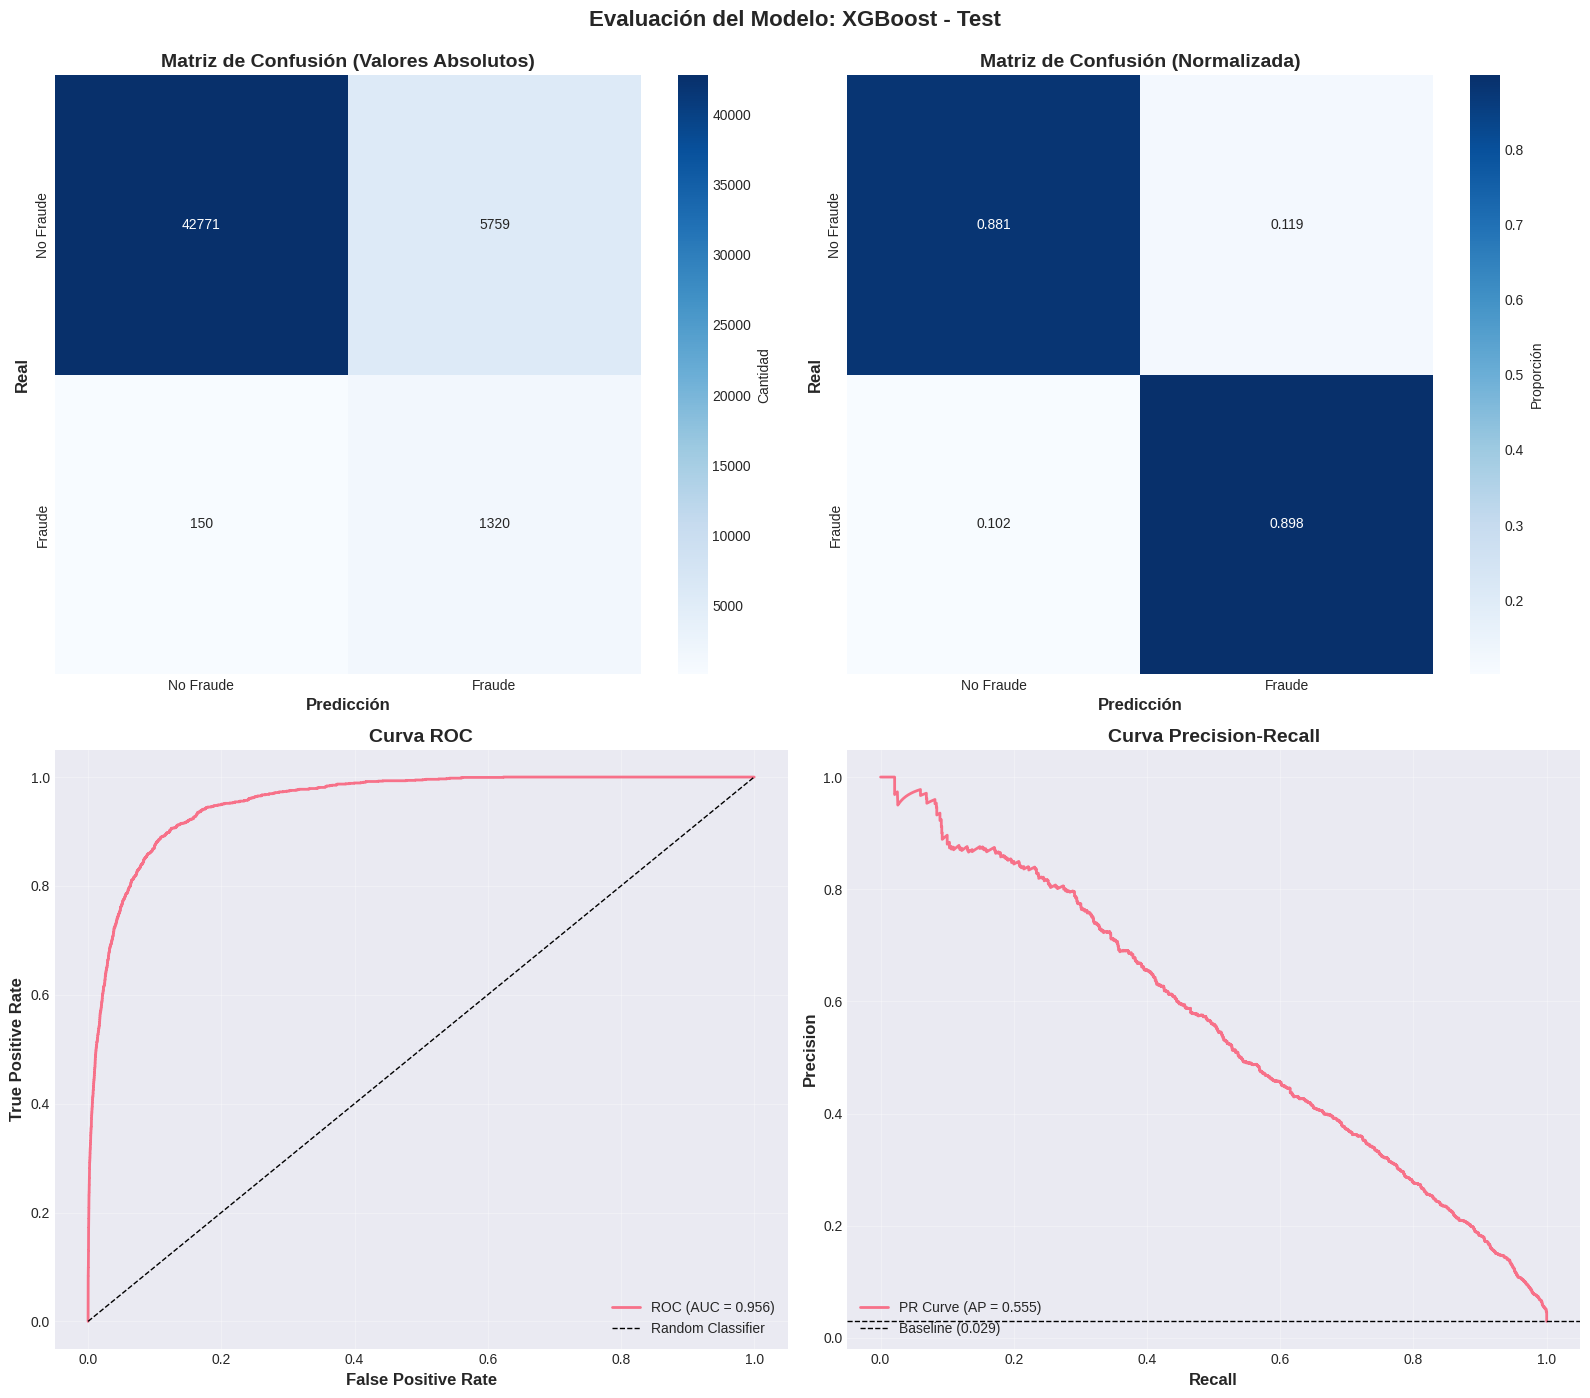

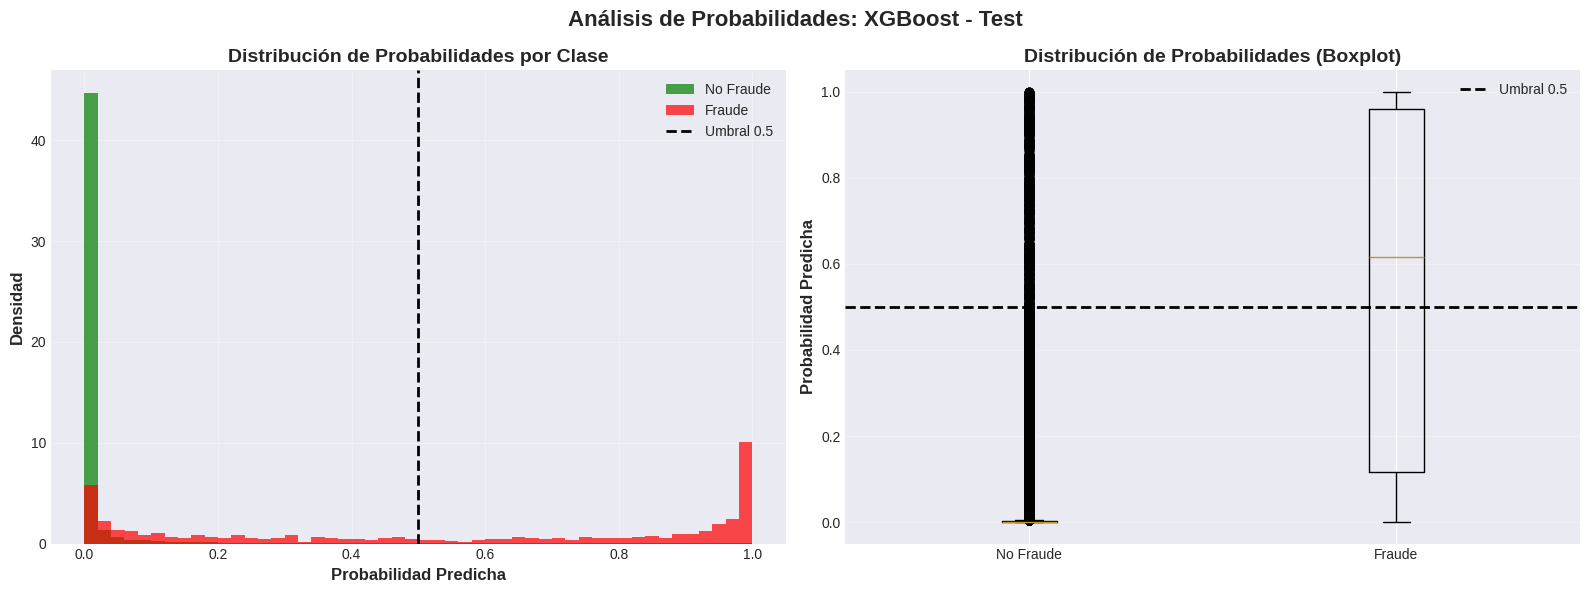

In [78]:
# Evaluar el modelo usando el threshold óptimo por costo y la función evaluate_model
# Obtener probabilidades predichas
y_proba_train = classifier.predict_proba(X_train)[:, 1]
y_proba_test = classifier.predict_proba(X_test)[:, 1]

# Predecir usando threshold óptimo por costo
y_pred_train_optimo_costo = (y_proba_train >= threshold_optimo_costo).astype(int)
y_pred_test_optimo_costo = (y_proba_test >= threshold_optimo_costo).astype(int)


# Evaluar en TEST con threshold óptimo por costo
print("\n" + "=" * 80)
print("RESULTADOS TEST (Threshold Óptimo por Costo)")
print("=" * 80)
metrics_test_costo = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_costo,
    model_name="XGBoost - Test",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)